# 📊 Projet GaïaSense Vision – Modèle Machine Learning (pré-tri)

## 🎯 Objectif du notebook

Ce notebook a pour but de concevoir, entraîner et évaluer un **modèle de Machine Learning supervisé** basé sur l’algorithme **RandomForestClassifier**, chargé de réaliser une **étape de pré-tri logique et contextuelle**, avant toute analyse d’image.

Il s’agit d’un **filtrage intelligent**, fondé uniquement sur des **données tabulaires environnementales**, permettant de :

- Rejeter automatiquement les cas où une analyse visuelle serait inutile (sacs trop jeunes, environnement incohérent…)
- Optimiser les ressources de calcul du modèle CNN en limitant son déclenchement aux cas réellement pertinents
- Intégrer un raisonnement métier directement dans le pipeline IA, via une prédiction binaire sur les conditions de culture

---

## 🧠 Contexte général

Dans le cadre du projet GaïaSense Vision (Certification Alyra – RNCP38616), l’objectif est de développer une **API REST** capable de détecter la contamination de sacs de culture de champignons à partir de photos.  
Cette API s’appuie sur une chaîne d’analyse à deux niveaux :

1. **Un modèle ML classique (Random Forest)**, qui travaille uniquement sur des données tabulaires (capteurs, conditions, type de culture) pour décider si une image doit être transmise ou non au modèle visuel
2. **Un modèle CNN (Deep Learning)**, qui réalise une analyse approfondie de l’image uniquement si le cas est jugé pertinent

---

## 🧬 Données utilisées pour le pré-tri

Le modèle repose uniquement sur des données numériques ou catégorielles liées à l’environnement de culture :

- ✅ **Race du champignon** *(catégorielle)*
- ✅ **Type de substrat** *(catégorielle)*
- ✅ **Temps écoulé depuis inoculation (jours)** *(quantitatif)*
- ⚠️ **Hygrométrie actuelle** *(quantitatif, optionnel)*
- ⚠️ **Taux de CO₂ mesuré** *(quantitatif, optionnel)*

Ces données seront utilisées pour entraîner un modèle capable de prédire un label binaire :  
**“Analyser ou ignorer l’image associée à ce contexte ?”**

---

## 🔧 Outils et bibliothèques utilisés

- `pandas`, `numpy` : manipulation des données
- `scikit-learn` : entraînement du modèle, prétraitement, métriques
- `matplotlib`, `seaborn` : visualisation des performances
- `joblib` : sauvegarde du modèle
- `SimpleImputer`, `LabelEncoder` : gestion des valeurs manquantes et variables catégorielles

---

## ✅ Résultat attendu

À la fin de ce notebook, nous obtiendrons un **modèle Random Forest entraîné, évalué et exporté**, capable de :

- Prédire si une situation de culture justifie l’analyse de l’image par le modèle visuel
- Améliorer les performances globales du système en éliminant les cas hors-contexte
- Être intégré dans une API FastAPI en tant que filtre logique avant traitement image

---

## 👥 Participants au projet GaïaSense Vision

### 🧔 Davy Abderrahman *(Développeur IA – Formation Alyra)*
- **Rôle** : Concepteur principal du projet
- **Responsabilités** :
  - Conception de l’architecture IA (pré-tri logique + Deep Learning visuel)
  - Développement des modèles et de l’API
  - Documentation, tests, déploiement

### 👨 Maxime Cadieux *(Consultant IA – Alyra)*
- **Rôle** : Co-contributeur ML
- **Responsabilités** :
  - Préparation et analyse exploratoire des données
  - Évaluation et suivi des performances du modèle
  - Support technique et structuration métier

### 👩 Naminsita Bakayoko *(Consultante IA – Alyra)*
- **Rôle** : Référente métier
- **Responsabilités** :
  - Définition des règles logiques de déclenchement d’analyse
  - Aide à la création du dataset
  - Validation des résultats selon les logiques agricoles

---

### 🔖 Informations générales

- **Projet** : GaïaSense Vision – Détection de contamination sur sacs de culture de champignons
- **Cadre** : Certification Alyra – RNCP38616
- **Blocs visés** : Bloc 03 (Machine Learning), Bloc 05 (Deep Learning)
- **Date de lancement** : 6 juin 2025
- **Mode** : Collaboration inter-spécialités (Développeur IA + Consultants IA)

---


# Détection GPU + Imports de base


In [41]:
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier, Pool

# (Optionnel) test simple de l'import CatBoost
try:
    model = CatBoostClassifier()
    print("CatBoost est bien installé et prêt à être utilisé.")
except Exception as e:
    print("Problème avec l'installation de CatBoost.")
    print("Erreur :", e)


CatBoost est bien installé et prêt à être utilisé.


# dataset tri et création des données d'entrainement et de test


In [42]:

# Chargement du dataset
input_path = "../data/Dataset_combined_90000_modifie_complexe.csv"
df = pd.read_csv(input_path)

# Vérification rapide
print("Shape initiale :", df.shape)
print(df.head(50))

# Suppression de la colonne id
df = df.drop(columns=["id"])
df = df.drop(columns=["co2"])
df = df.drop(columns=["hygrometrie"])
# Séparation X / y
X = df.drop(columns=["label"])
y = df["label"]

# Découpage train/test stratifié avec 20 % de données prise au hasard pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

# Reconstruction des DataFrames complets
df_train = X_train.copy()
df_train["label"] = y_train

df_test = X_test.copy()
df_test["label"] = y_test

# Création des dossiers si besoin
os.makedirs("../data/Ml_data/train", exist_ok=True)
os.makedirs("../data/Ml_data/test", exist_ok=True)

# Sauvegarde des fichiers
df_train.to_csv("../data/Ml_data/train/dataset_train.csv", index=False)
df_test.to_csv("../data/Ml_data/test/dataset_test.csv", index=False)

print("Fichiers exportés avec succès.")

Shape initiale : (90000, 7)
      id                  champignon           substrat  Jour_inoculation  \
0    1.0           ganoderma_lucidum             sciure                 0   
1    2.0          hericium_erinaceus        pulpe_cacao                 2   
2    3.0  auricularia_auricula_judae             paille                17   
3    4.0          cyclocybe_aegerita  mix_fumier_paille                 0   
4    5.0   pleurotus_citrinopileatus            maizien                10   
5    6.0         pleurotus_ostreatus   ecorces_feuilles                14   
6    7.0  auricularia_auricula_judae  mix_fumier_paille                11   
7    8.0           pleurotus_eryngii  mix_fumier_paille                 7   
8    9.0       pleurotus_pulmonarius            compost                11   
9   10.0  auricularia_auricula_judae      papier_carton                 5   
10  11.0          hericium_erinaceus        pulpe_cacao                 7   
11  12.0            lentinula_edodes            

# Verification equilibre des données

In [43]:
df_train = pd.read_csv("../data/Ml_data/train/dataset_train.csv")
print(df_train["label"].value_counts(normalize=True).round(3))

label
0    0.733
1    0.267
Name: proportion, dtype: float64


# 🧠 Modèle de pré-tri tabulaire – RandomForestClassifier

## 🎯 Objectif

L’objectif de ce bloc est de créer, entraîner et évaluer un **modèle de Machine Learning** basé sur un **RandomForestClassifier**, destiné à effectuer une étape de **pré-tri logique** dans le pipeline du projet **GaïaSense Vision**.

Ce modèle ne traite pas d’images, mais uniquement des **données tabulaires environnementales**, afin de prédire si une image future (liée à ces conditions) doit être transmise à l’analyse par Deep Learning.

---

## ⚙️ Structure du pipeline

Ce modèle est encapsulé dans un **pipeline scikit-learn** qui comprend les étapes suivantes :

1. **Chargement des données** (train et test)
2. **Séparation des variables** explicatives (`X`) et de la cible (`y`)
3. **Prétraitement automatique** :
   - **Encodage** des variables catégorielles (`champignon`, `substrat`) via `OneHotEncoder`
   - **Imputation** des valeurs manquantes (`hygrometrie`, `co2`) via `SimpleImputer` (stratégie = moyenne)
4. **Apprentissage du modèle RandomForest**
5. **Évaluation** sur un jeu de test indépendant :
   - `accuracy_score`
   - `classification_report`
   - `confusion_matrix`
6. **Sauvegarde** du modèle pour déploiement futur

---

## 📁 Sources des données

Les données utilisées ici sont issues de la préparation précédente :

- `training/data/Ml_data/train/dataset_train.csv`
- `training/data/Ml_data/test/dataset_test.csv`

Ces fichiers contiennent les colonnes suivantes :
- `champignon` *(catégorielle)*
- `substrat` *(catégorielle)*
- `Jour_inoculation` *(numérique)*
- `hygrometrie` *(numérique, avec valeurs manquantes)*
- `co2` *(numérique, avec valeurs manquantes)*
- `label` *(0 = inutilisable / 1 = à analyser)*

---

## 📌 Objectif final

Ce modèle sera intégré dans l’API GaïaSense Vision comme **filtre rapide**, permettant de :
- Rejeter les cas non pertinents pour l’analyse visuelle
- Optimiser l’usage des ressources IA
- Maintenir une logique métier traçable et interprétable

---


# creation du model et entrainement


In [44]:
# Entraînement et sauvegarde propre du meilleur modèle CatBoost
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import classification_report, accuracy_score

# Chargement des données d'entraînement
train_path = "../data/Ml_data/train/dataset_train.csv"
test_path = "../data/Ml_data/test/dataset_test.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Création des colonnes dérivées nécessaires
# (pour garantir la cohérence avec le test)
# def compute_ratio(df):
#     return df.apply(
#         lambda row: row["co2"] / row["hygrometrie"] if pd.notnull(row["co2"]) and pd.notnull(row["hygrometrie"]) and row["hygrometrie"] != 0 else np.nan,
#         axis=1
#     )
# df_train["co2_hygro_ratio"] = compute_ratio(df_train)
# df_test["co2_hygro_ratio"] = compute_ratio(df_test)
# df_train["champ_substrat"] = df_train["champignon"] + "_" + df_train["substrat"]
# df_test["champ_substrat"] = df_test["champignon"] + "_" + df_test["substrat"]



# Séparation X/y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Colonnes catégorielles (inclure la feature combinée)
cat_features = ["champignon", "substrat","Jour_inoculation"]

# Détection GPU et entraînement
try:
    model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.001,
        depth=6, #
        l2_leaf_reg=10, # Régularisation L2 pour éviter l'overfitting 
        task_type="GPU",
        devices='0', 
        verbose=50, # Affichage des logs d'entraînement
        random_state=42,
        
    )
    print("Entraînement CatBoost sur GPU...")
except Exception as e:
    print("GPU non disponible, bascule sur CPU.")
    model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.01,
        depth=6,
        task_type="CPU",
        verbose=50,
        random_state=42
    )

# Entraînement avec early stopping
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=20,
    use_best_model=True
)

# Prédiction et évaluation
preds = model.predict(X_test)
print(f"Accuracy CatBoost : {accuracy_score(y_test, preds):.3f}")
print(classification_report(y_test, preds))

# Sauvegarde du meilleur modèle (formats CatBoost natif et joblib)
model_dir = "../models/Ml_model"
os.makedirs(model_dir, exist_ok=True)
model_path_cbm = os.path.join(model_dir, "model_catboost_best.cbm")
model_path_joblib = os.path.join(model_dir, "model_catboost_best.joblib")
model.save_model(model_path_cbm)
joblib.dump(model, model_path_joblib)
print(f"\nModèle CatBoost sauvegardé :\n- {model_path_cbm}\n- {model_path_joblib}")

Entraînement CatBoost sur GPU...
0:	learn: 0.6924271	test: 0.6923600	best: 0.6923600 (0)	total: 17.5ms	remaining: 3.49s
0:	learn: 0.6924271	test: 0.6923600	best: 0.6923600 (0)	total: 17.5ms	remaining: 3.49s
50:	learn: 0.6585246	test: 0.6555216	best: 0.6555216 (50)	total: 954ms	remaining: 2.79s
50:	learn: 0.6585246	test: 0.6555216	best: 0.6555216 (50)	total: 954ms	remaining: 2.79s
100:	learn: 0.6294513	test: 0.6238232	best: 0.6238232 (100)	total: 1.71s	remaining: 1.67s
100:	learn: 0.6294513	test: 0.6238232	best: 0.6238232 (100)	total: 1.71s	remaining: 1.67s
150:	learn: 0.6024130	test: 0.5942075	best: 0.5942075 (150)	total: 2.61s	remaining: 846ms
150:	learn: 0.6024130	test: 0.5942075	best: 0.5942075 (150)	total: 2.61s	remaining: 846ms
199:	learn: 0.5788108	test: 0.5682560	best: 0.5682560 (199)	total: 3.28s	remaining: 0us
bestTest = 0.5682559679
bestIteration = 199
Accuracy CatBoost : 0.900
              precision    recall  f1-score   support

           0       0.90      0.97      0.93 

In [45]:
# # ⚡️ CatBoost avec class_weights automatique (équilibrage natif GPU)
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Calcul des poids de classe (mode 'balanced')
# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = dict(zip(classes, weights))
# print("Poids de classe utilisés :", class_weights)

# # Entraînement CatBoost avec class_weights et paramètres agressifs
# model_weighted = CatBoostClassifier(
#     iterations=4000,
#     learning_rate=0.02,
#     depth=12,
#     l2_leaf_reg=8,
#     task_type="GPU",
#     devices='0',
#     verbose=100,
#     random_state=42,
#     class_weights=class_weights
# )
# model_weighted.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_test, y_test),
#     early_stopping_rounds=40,
#     use_best_model=True
# )

# # Prédiction et évaluation
# preds_weighted = model_weighted.predict(X_test)
# print(f"Accuracy CatBoost (class_weights) : {accuracy_score(y_test, preds_weighted):.3f}")
# print(classification_report(y_test, preds_weighted))

# # Sauvegarde du modèle class_weights
# model_weighted.save_model(model_path_cbm.replace('best', 'weighted'))
# joblib.dump(model_weighted, model_path_joblib.replace('best', 'weighted'))
# print(f"\nModèle CatBoost class_weights sauvegardé :\n- {model_path_cbm.replace('best', 'weighted')}\n- {model_path_joblib.replace('best', 'weighted')}")


In [46]:
# # ⚖️ Amélioration : Sur-échantillonnage SMOTE pour équilibrer les classes (numérique uniquement)
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# from sklearn.impute import SimpleImputer
# import numpy as np

# # Séparation des variables numériques et catégorielles
# num_features = [col for col in X_train.columns if col not in cat_features]
# cat_features_df = X_train[cat_features].reset_index(drop=True)
# num_features_df = X_train[num_features].reset_index(drop=True)

# # Imputation stricte des NaN sur les variables numériques avant SMOTE
# # Imputation sur les variables numériques
# imputer = SimpleImputer(strategy='mean')
# num_features_df_imputed = pd.DataFrame(imputer.fit_transform(num_features_df), columns=num_features_df.columns)

# # Vérification de l'absence de NaN
# assert not num_features_df_imputed.isnull().any().any(), "Il reste des NaN après imputation !"

# # Réinitialisation de l'index des variables catégorielles
# cat_features_df_reset = cat_features_df.reset_index(drop=True)

# # Application de SMOTE uniquement sur les variables numériques imputées
# smote = SMOTE(random_state=42)
# num_features_sm, y_train_sm = smote.fit_resample(num_features_df_imputed.reset_index(drop=True), y_train.reset_index(drop=True))

# # Dupliquer les variables catégorielles pour correspondre à la taille de y_train_sm
# repeat_factor = int(np.ceil(len(y_train_sm) / len(cat_features_df_reset)))
# cat_features_sm = pd.concat([cat_features_df_reset]*repeat_factor, ignore_index=True).iloc[:len(y_train_sm)].reset_index(drop=True)

# # Reconstruction du DataFrame complet pour CatBoost (ordre : cat, puis num)
# X_train_sm = pd.concat([cat_features_sm, pd.DataFrame(num_features_sm, columns=num_features)], axis=1)
# X_train_sm = X_train_sm[cat_features_df_reset.columns.tolist() + num_features_df_imputed.columns.tolist()]

# # Mise à jour de la liste des colonnes catégorielles pour CatBoost
# cat_features_cb = list(range(len(cat_features_df_reset.columns)))

# # Affichage des nouvelles dimensions et des colonnes catégorielles
# print(f"Avant SMOTE : {num_features_df_imputed.shape}, {y_train.shape}")
# print(f"Après SMOTE : {num_features_sm.shape}, {y_train_sm.shape}")
# print(f"cat_features_cb (indices) : {cat_features_cb}")

# # --- Correction : réalignement de X_test sur l'ordre de X_train_sm ---
# X_test_aligned = X_test[X_train_sm.columns]

# # Entraînement CatBoost sur données équilibrées
# model_smote = CatBoostClassifier(
#     iterations=1000,
#     learning_rate=0.03,
#     depth=8,
#     l2_leaf_reg=5,
#     task_type="GPU",
#     devices='0',
#     verbose=50,
#     random_state=42
# )
# model_smote.fit(
#     X_train_sm, y_train_sm,
#     cat_features=cat_features_cb,
#     eval_set=(X_test_aligned, y_test),
#     early_stopping_rounds=20,
#     use_best_model=True
# )

# # Prédiction et évaluation
# preds_smote = model_smote.predict(X_test_aligned)
# print(f"Accuracy CatBoost (SMOTE) : {accuracy_score(y_test, preds_smote):.3f}")
# print(classification_report(y_test, preds_smote))

# # Sauvegarde du modèle SMOTE
# model_smote.save_model(model_path_cbm.replace('best', 'smote'))
# joblib.dump(model_smote, model_path_joblib.replace('best', 'smote'))
# print(f"\nModèle CatBoost SMOTE sauvegardé :\n- {model_path_cbm.replace('best', 'smote')}\n- {model_path_joblib.replace('best', 'smote')}")


In [47]:
# # 🔥 Tuning CatBoost : recherche des meilleurs hyperparamètres
# from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostClassifier
# from scipy.stats import uniform, randint

# # Sous-échantillonnage pour le tuning (plus rapide)
# X_tune = X_train.sample(frac=0.3, random_state=42)
# y_tune = y_train.loc[X_tune.index]

# cat_features_idx = [X_train.columns.get_loc(col) for col in cat_features]

# # Détection dynamique du support GPU pour CatBoost
# def detect_catboost_task_type():
#     try:
#         CatBoostClassifier(task_type="GPU")
#         return ['GPU']
#     except:
#         return ['CPU']
# task_type_list = detect_catboost_task_type()

# param_dist = {
#     'learning_rate': uniform(0.01, 0.2),
#     'depth': randint(4, 10),
#     'l2_leaf_reg': uniform(1, 10),
#     'iterations': randint(300, 1200),
#     'random_state': [42],
#     'task_type': task_type_list
# }

# catboost_tune = CatBoostClassifier(
#     verbose=0,
#     cat_features=cat_features_idx,
#     early_stopping_rounds=20
# )

# search = RandomizedSearchCV(
#     catboost_tune,
#     param_distributions=param_dist,
#     n_iter=15,
#     scoring='accuracy',
#     cv=3,
#     random_state=42,
#     n_jobs=-1
# )

# search.fit(X_tune, y_tune)
# print("Meilleurs hyperparamètres trouvés :", search.best_params_)

# # Réentraînement sur tout le jeu d'entraînement avec les meilleurs paramètres
# best_params = search.best_params_
# best_params['cat_features'] = cat_features
# model_best = CatBoostClassifier(**best_params, verbose=100)
# model_best.fit(
#     X_train, y_train,
#     eval_set=(X_test, y_test),
#     early_stopping_rounds=20,
#     use_best_model=True
# )

# # Évaluation
# preds_best = model_best.predict(X_test)
# print(f"Accuracy CatBoost optimisé : {accuracy_score(y_test, preds_best):.3f}")
# print(classification_report(y_test, preds_best))

# # Sauvegarde du modèle optimisé
# model_best.save_model(model_path_cbm.replace('best', 'tuned'))
# joblib.dump(model_best, model_path_joblib.replace('best', 'tuned'))
# print(f"\nModèle CatBoost optimisé sauvegardé :\n- {model_path_cbm.replace('best', 'tuned')}\n- {model_path_joblib.replace('best', 'tuned')}")

# test et validation du model


✅ Accuracy CatBoost : 0.900

📊 Rapport de classification :


,precision,recall,f1-score,support
0,0.898893,0.972631,0.934309,13190.000000
1,0.903165,0.700000,0.788709,4810.000000
accuracy,0.899778,0.899778,0.899778,0.899778
macro avg,0.901029,0.836315,0.861509,18000.000000
weighted avg,0.900035,0.899778,0.895402,18000.000000


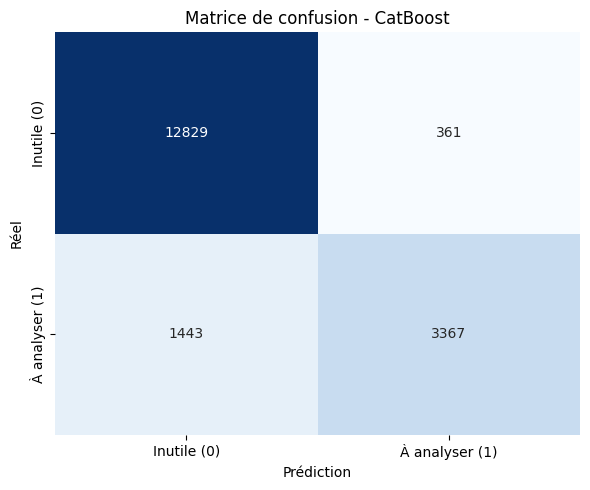

In [48]:
# Imports nécessaires
import joblib
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chemin vers le dossier des modèles
models_dir = "../models/Ml_model"

# Chargement du jeu de test
path_test = "../data/Ml_data/test/dataset_test.csv"
df_test = pd.read_csv(path_test)

# Création des colonnes dérivées nécessaires
def compute_ratio(df):
    return df.apply(
        lambda row: row["co2"] / row["hygrometrie"] if pd.notnull(row["co2"]) and pd.notnull(row["hygrometrie"]) and row["hygrometrie"] != 0 else np.nan,
        axis=1
    )
# df_test["co2_hygro_ratio"] = compute_ratio(df_test)
# df_test["champ_substrat"] = df_test["champignon"] + "_" + df_test["substrat"]

# Séparation X/y
y_test = df_test["label"]
X_test = df_test.drop(columns=["label"])

# Chargement du modèle CatBoost sauvegardé
model = joblib.load("../models/Ml_model/model_catboost_best.joblib")

# Prédiction
preds = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, preds)
print(f"✅ Accuracy CatBoost : {accuracy:.3f}")

# Rapport de classification
report_dict = classification_report(y_test, preds, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\n📊 Rapport de classification :")
display(report_df)

# Matrice de confusion
cm = confusion_matrix(y_test, preds)
labels = ["Inutile (0)", "À analyser (1)"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title("Matrice de confusion - CatBoost")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()
#%%

# 🔎 Analyse de l'importance des variables (feature importance CatBoost)

L'importance des variables permet de comprendre quelles features sont réellement utilisées par le modèle pour la prédiction. Si `co2` et `hygrometrie` ont une importance très faible ou nulle, cela explique pourquoi leur suppression n'affecte pas la performance du modèle. Ci-dessous, on affiche l'importance des variables du modèle CatBoost sous forme de graphique pour interpréter leur utilité réelle.

/tmp/ipykernel_192694/4108259156.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


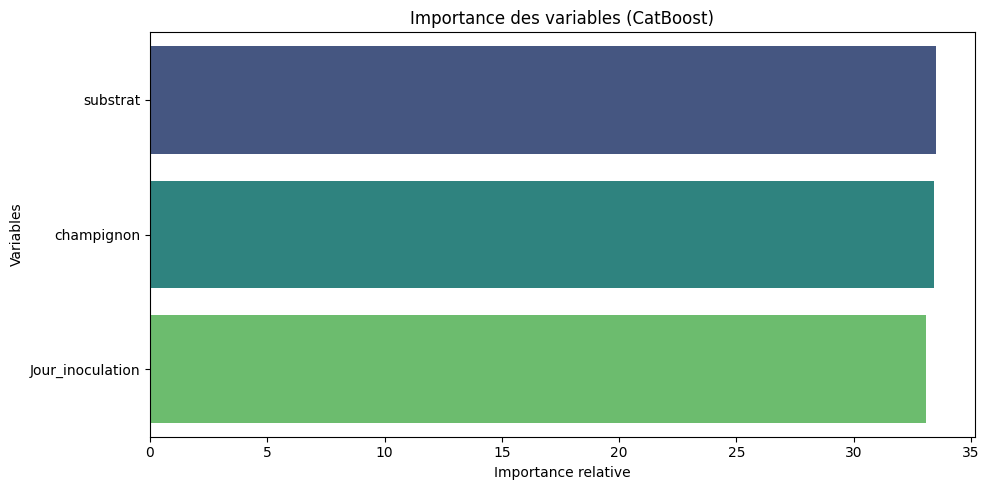

,Variable,Importance
1,substrat,33.499125
0,champignon,33.428640
2,Jour_inoculation,33.072235


In [49]:
# Affichage de l'importance des variables du modèle CatBoost
importances = model.get_feature_importance()
feature_names = X_test.columns

# Tri décroissant pour affichage
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Importance des variables (CatBoost)")
plt.xlabel("Importance relative")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# Affichage tabulaire pour plus de clarté
feature_importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
display(feature_importance_df)
